This post shows a simulation of a quantum wave packet oscillating in a harmonic potential. For this we will be using the time-dependent Schrödinger equation.

The time-evolution of a state $\rvert \psi(t) \rangle$ of a quantum mechanical system is given by the (time-dependent) Schrödinger equation:

$$
i \hbar \frac{d}{dt} | \psi(t) \rangle = \hat{H} | \psi(t) \rangle \, ,
$$

where $\hat{H}$ is the Hamiltonian of the system. All possible states of a system show some
kind of time-evolution, but if the state is an eigenstate of the Hamiltonian

$$
\hat{H} | n \rangle = E_n | n \rangle 
$$

with $\vert \psi(0)\rangle = \vert n \rangle$ the time-dependence is just a rotation in the complex plane:

$$
| \psi(t) \rangle = e^{-i E_n t / \hbar} | n  \rangle \, .
$$

## Wave packet in the harmonic potential

The [quantum harmonic oscillator](https://znswanderer.github.io/physics/Harmonic-Oscillator-SymPy/) is given by:

$$
\hat H = \frac{1}{2m} \hat p^2 + \frac{1}{2} m \omega^2 \hat x^2
$$

and with 

$$
\hat p = - i \hbar \frac{\partial}{\partial x} \qquad \hat x = x
$$

in position space we get

$$
\hat H =-\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} + \frac{1}{2} m \omega^2 x^2 
$$

We are now implementing this system in `numpy`.

First we are discretizing a section of length $L$ of the (position) space $x \in [-L/2, L/2)$ around the
origin into $N$ points:

In [10]:
import numpy as np
from scipy import integrate, sparse
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Video

In [11]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
L = 6
N = 6*100 + 1
x = np.linspace(0, L, N) - L/2
dx = np.diff(x)[0]

# setting constants and parameters to some convenient numbers
hbar = 1
mass = 1
omega = 2 * np.pi

With this we define the Hamiltonian using sparse matrices (see this [blog post](https://znswanderer.github.io/physics/Harmonic-Oscillator-in-Discretized-Space/) for details):

In [13]:
# The second order derivative D2:
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2

# The position operator
X = sparse.diags([x], [0]) 

# The Hamiltonian for the harmonic oscillator
V = 0.5 * mass * omega**2 * (X @ X)
T = -(hbar**2 / (2 * mass)) * D2
H = T + V

We can use the sparse linear algebra package to find the ground state, which is a gaussian and therefore
a perfect starting point for our moving wave paket:

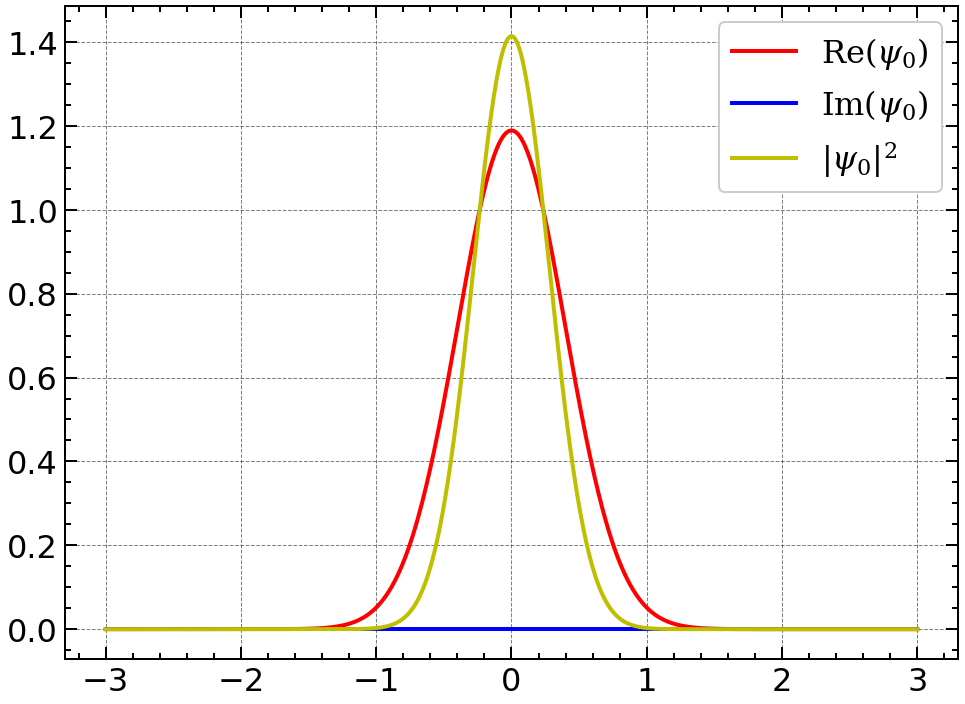

In [14]:
eigs, eigv = sparse.linalg.eigsh(H, k=20, which='SM')
# Test if all eigenvals are real (as expected)
assert all(np.isreal(eigs))

# Make complex normalized basis
basis = eigv.astype(complex)
basis /= np.sqrt(np.sum(np.abs(basis)**2, axis=0)*dx)  # norm the vector 

psi0 = basis.T[0]
psi0.real = np.abs(psi0.real) # for plot in the upper half

# Plot the ground state
plt.figure(figsize=(8,6))
plt.plot(x, psi0.real, 'r', label='$\mathrm{Re}(\psi_0)$')
plt.plot(x, psi0.imag, 'b', label='$\mathrm{Im}(\psi_0)$')
plt.plot(x, np.abs(psi0)**2, 'y', label='$|\psi_0|^2$')
plt.legend();

## Time-evolution

The momentum of the ground state

$$
\langle \psi_0 | \hat p | \psi_0 \rangle = -i \hbar \int \psi_0^*(x) \frac{\partial}{\partial x} \psi_0(x) dx \, = 0,
$$ 
is zero.

To check this in the discretized version we use the [symmetric derivative](https://en.wikipedia.org/wiki/Symmetric_derivative)
operator:

In [15]:
D_s = sparse.diags([-1, 1], [-1, 1], shape=(N, N)) / (2*dx)
P_s = - 1j * hbar * D_s

def avg_momentum(psi):
    return (psi.T.conj() @ (P_s @ psi)) * dx

# The average momentum is indeed zero (up to rounding)
np.round(avg_momentum(psi0), 2)

-0j

Now, let's give this gaussian packet a little boost!

In "Lectures on Quantum Mechanics" (1st ed.) Steven Weinberg gives in chapter 3.5 the unitary operator
for a spacial translation as

$$
\hat U_{\Delta x} = \exp \left( -i \hat p \Delta x / \hbar \right)
$$

but we are looking for a boost, which is a shift in momentum space. Without derivation we may 
just try the following form:

$$
\hat U_{\Delta p} = \exp \left( i \hat x \Delta p / \hbar \right)
$$

(The change in sign, because in Fourier transformations there is also a change in sign,
going from $x$ to $k$). 

The boosted wave packet will be:

$$
|\psi_{\Delta p} \rangle = \hat U_{\Delta p} |\psi_0 \rangle \, .
$$

In [16]:
def boost(dp):
    return sparse.diags([np.exp(1j * x * dp / hbar)], [0]) 

# Boosting some momentum units:
U_dp = boost(dp=9)
psi_dp = U_dp @ psi0

# Measure the average momentum
np.round(avg_momentum(psi_dp), 2)

(8.99+0j)

This seems to work!

The plot of the boosted ground state looks like this:

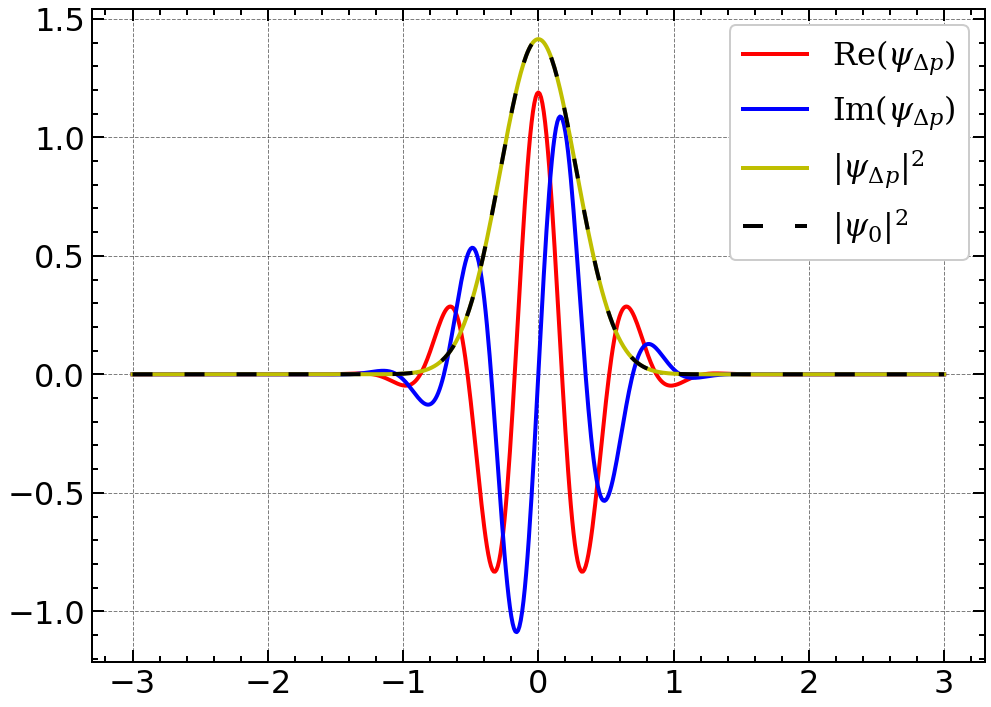

In [17]:
plt.figure(figsize=(8,6))
plt.plot(x, psi_dp.real, 'r', label='$\mathrm{Re}(\psi_{\Delta p})$')
plt.plot(x, psi_dp.imag, 'b', label='$\mathrm{Im}(\psi_{\Delta p})$')
plt.plot(x, np.abs(psi_dp)**2, 'y', label='$|\psi_{\Delta p}|^2$')
plt.plot(x, np.abs(psi0)**2, color='k', label='$|\psi_0|^2$', linestyle=(0, (5, 8)), linewidth=2)
plt.legend();

In the comparison with the un-boosted packet $\psi_0$ it's nice to see, that
the boost really only affects the momentum: the probability density in
position space, $|\psi|^2$, is unchanged.

We can also see, that the number of nodes in the boosted wave packet has increased,
which shows a larger overall energy.

For the time integration we will use a Runge-Kutta solver from `scipy.integrate.solve_ivp`. This 
will solve an ODE of the form:

```
dy / dt = f(t, y)
y(t0) = y0
```

Here the ODE is the Schrödinger equation:

$$
\frac{d}{dt} \psi(t) = -\frac{i}{\hbar} \hat H \psi(t)
$$

or the RHS as python code:

```python
f(t, psi) = (-1j / hbar) * (H @ psi)
```

This integration is done in the following:

In [18]:
t_eval = np.linspace(0, 1, 201)
sol = integrate.solve_ivp(lambda t, psi: (-1j / hbar) * (H @ psi), 
                          t_span = [t_eval[0], t_eval[-1]], y0 = psi_dp, t_eval = t_eval, method="RK23")

In [19]:
class WaveAnimation:
    def __init__(self, x_vec, psi_t, V_vec, t_vec, figsize=(6,4), ylim=(-1.5, 2)):
        self.x_vec = x_vec
        self.psi_t = psi_t
        self.V_vec = V_vec
        self.t_vec = t_vec
        self.fig = plt.figure(figsize=figsize)
        self.ax1 = ax1 = plt.subplot(1,1,1)
        ax1.set_xlim(x_vec[0], x_vec[-1])
        ax1.set_ylim(*ylim)
        self.title = ax1.set_title('')
        self.line1, = ax1.plot([], [], "k--")
        self.line1.set_linewidth(1)
        self.line2, = ax1.plot([], [], 'r')
        self.line3, = ax1.plot([], [], 'b')
        self.line4, = ax1.plot([], [], 'y')

    def init_anmimation(self):
        self.line1.set_data(self.x_vec, self.V_vec)
        return self.line1,

    def get_frame(self, i):
        psi = self.psi_t[:, i]
        self.line2.set_data(self.x_vec, psi.real)
        self.line3.set_data(self.x_vec, psi.imag)
        self.line4.set_data(self.x_vec, np.abs(psi)**2)
        self.title.set_text('Time = %1.3f' % self.t_vec[i])
        return self.line1,
    
    def animation(self):
        anim = animation.FuncAnimation(self.fig, self.get_frame, init_func=self.init_anmimation,
                                       frames=len(self.t_vec), interval=50, blit=True)
        return anim
    
    def save_mp4(self, filename):
        ffwriter = animation.FFMpegWriter(fps=20, extra_args=['-vcodec', 'libx264'])
        anim = self.animation()
        anim.save(filename, dpi=300, writer=ffwriter)
        plt.close()   # to prevent the last frame from showing in notebook

The class `WaveAnimation` manages the creation of a mp4-video file from a time-array of wave vectors. The source for the class is given in the corresponding jupyter notebook.

In [20]:
V_dummy = 0.5 * mass * omega**2 * x**2 * 0.02   # Scaled to 0.02 for the animation
WaveAnimation(x, psi_t=sol.y, V_vec=V_dummy , t_vec=sol.t).save_mp4('wave_bf.mp4')

Video('wave_bf.mp4', width=600)

One can clearly see, that at the point of the highest velocity the number of nodes is large and
at the reversal point we see no nodes.

The width of the wave paket stays constant, which is because of the special form of the
harmonic potential. For example, a wave paket for the free particle (i.e. no potential) will
become wider with increasing time (dispersion). 

## Time evolution using the energy eigenbasis

We can express a wave function in the energy eigenbasis:

$$
| \psi \rangle = \sum_n |n \rangle \langle n | \psi \rangle = \sum_n a_n |n \rangle
$$

As the Schrödinger equation is a *linear* equation, we can write

$$
\frac{d}{dt} | \psi (t)\rangle = \sum_n a_n \frac{d}{dt} |n \rangle
= - \sum_n a_n \frac{i}{\hbar} \hat H |n \rangle
= - \sum_n a_n \frac{i}{\hbar} E_n |n \rangle
$$

and the solution is

$$
| \psi (t)\rangle = \sum_n a_n e^{-i E_n t / \hbar} |n \rangle
$$

This means for the norm:

$$
\langle \psi | \psi \rangle = \sum_n |\langle n | \psi \rangle |^2 = 1
$$

Let's test if this is valid:

In [12]:
np.round(np.sum(np.abs(basis.T.conj() @ psi_dp * dx)**2), 2)

1.0

One can look for the spectrum in the energy eigenbasis:

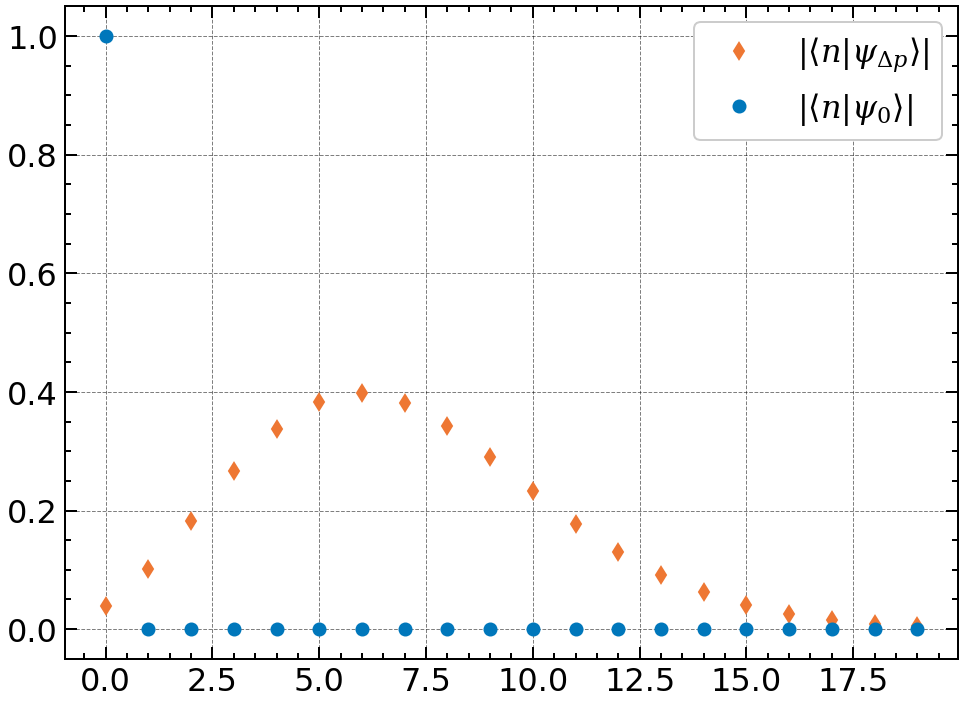

In [45]:
plt.figure(figsize=(8,6))
plt.plot(np.abs(basis.T.conj() @ psi_dp) * dx, 'd', label=r"$|\langle n | \psi_{\Delta p} \rangle |$")
plt.plot(np.abs(basis.conj().T @ psi0 * dx), 'o', label=r"$|\langle n | \psi_0 \rangle |$")
plt.legend();

The blue dots show the spectrum of the un-boosted ground state and we clearly see, that all the coefficients of the
higher eigenstates are zero, as expected. The boosted wave paket, orange dots, has non-zero coefficients for
higher energy states, which is because this particle has a higher kinetic energy.

With this we can now use the form of the time evolution in the energy basis

$$
| \psi (t)\rangle = \sum_n a_n e^{-i E_n t / \hbar} |n \rangle
$$

to get the movement of the wave packet without doing any numerical integration!

This can be seen in the following:

In [51]:
an = basis.conj().T @ psi_dp * dx
En = eigs

t = 0.25
def psi_t(t):
    psi_t = np.sum(an * np.exp(-1j * En * t/ hbar) * basis, axis=1)
    return psi_t

sol2 = np.array([psi_t(t) for t in t_eval]).T

WaveAnimation(x, psi_t=sol2, V_vec=V_dummy , t_vec=t_eval).save_mp4('wave_eigs.mp4')

Video('wave_eigs.mp4', width=600)

## Notes

* Heavily inspired from Cory Chu: [Solving 1-D Schrodinger Equation in Python](https://blog.gwlab.page/solving-1-d-schrodinger-equation-in-python-dcb3518ce454).

* The oscillation of the wave packet in the harmonic oscillator can be described by the [Ehrenfest Theorem](https://en.wikipedia.org/wiki/Ehrenfest_theorem).

* The boosted ground state of the harmonic oscillator is also known as a [Coherent States](https://en.wikipedia.org/wiki/Coherent_state).